In [1]:
# Imports
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import levene, f_oneway, mode, shapiro, f

# Visualisation imports
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from holisticai.robustness.metrics.sensitivity_analysis import *

# <font color='deepskyblue'>Generate and visualise synthetic data

### <font color='red'>Generate synthetic data

We create binary data which overlaps. Changing 'cluster_std' causes the data to overlap more widely making it more difficult for a classifier to separate the two classes.

In [2]:
# generate synthetic data
X, Y = make_blobs(n_samples = 1000, centers=2, n_features=50, cluster_std=30, random_state=42)
# scale the features
X = StandardScaler().fit_transform(X)

### <font color='red'>Display data

We perform PCA analysis in order to isolate the data features which show the greatest variability. We then graph in 2D and 3D to get some intuition of how the data appears.

In [3]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)

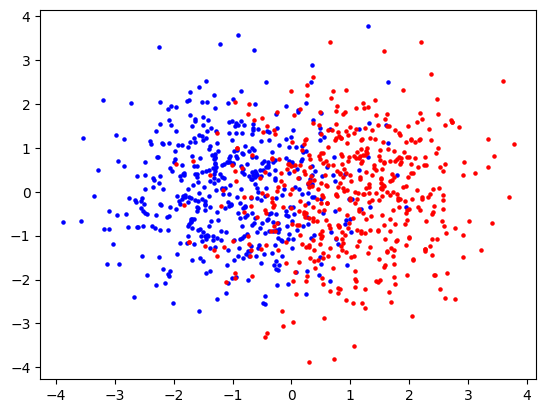

In [4]:
plt.scatter(principalComponents[np.where(Y==0),0], principalComponents[np.where(Y==0),1], s=5, color='blue')
plt.scatter(principalComponents[np.where(Y==1),0], principalComponents[np.where(Y==1),1], s=5, color='red')
plt.show()

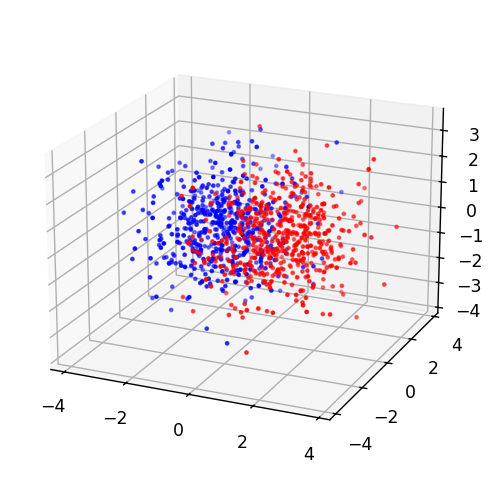

In [5]:
# %matplotlib qt
%matplotlib inline

fig = plt.figure(dpi=125)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalComponents[np.where(Y==0),0], principalComponents[np.where(Y==0),1],\
           principalComponents[np.where(Y==0),2], s=3, color='blue')
ax.scatter(principalComponents[np.where(Y==1),0], principalComponents[np.where(Y==1),1],\
           principalComponents[np.where(Y==1),2], s=3, color='red')
ax.view_init(elev=20, azim=-66)

# <font color='deepskyblue'>Train model


Here we train a traditional Machine Learning model, Logistic Regression, over our data. We are looking to investigate the impact of adding noise to the generalised data to which the model might be exposed, as opposed to investigating how to tune hyperparameters to yield the best outright performance - as such, we will only split our data into a training set and a test set (with no validation split).

### Split the dataset

In [6]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)


### Train a logistic regression model and compute baseline performance

Using standard settings, trained over the training set.

In [7]:
model = LogisticRegression(random_state=42)
model.fit(trainX, trainY)
predictions = model.predict(testX)

accuracyBase = accuracy_score(predictions, testY)
accuracyBase


0.8066666666666666

The performance of our trained logistic regression model over test data over which no noise has been added in terms of prediction accuracy is 80.67%. 

# <font color='deepskyblue'>Isolate the amount of noise needed to generate significant performance disparity

### Compute model performance over noisy test data

Progressively add more noise until we find that there has been a statistically significant change in model performance over the noisy test data as compared to the baseline performance of the model over the test data in the absence of noise. We will use the one-way ANOVA test to check for significance.

In [8]:
noiseFactor = 0
numberOfNoiseIterations = 100
alpha = 0.05

significantPerformanceChangeFound = False

while significantPerformanceChangeFound == False:

    noiseFactor += 0.01
    noisyAccuracyList = generateNoisyAccuracyList(testX, testY, model, noiseFactor=noiseFactor, numberOfNoiseIterations=numberOfNoiseIterations)
    if f_oneway([accuracyBase], noisyAccuracyList)[1] < alpha:
        significantPerformanceChangeFound = True
        print('Noise factor required for significant performance deviation = {:.2f}. Baseline performance = {:.2%}, Mean noisy performance = {:.2%}.' \
              .format(noiseFactor, accuracyBase, np.mean(noisyAccuracyList)))

    if noiseFactor == 1 and significantPerformanceChangeFound == False:
        significantPerformanceChangeFound = True
        print('Maximum noise reached without significant performance deviation.')

Noise factor required for significant performance deviation = 0.24. Baseline performance = 80.67%, Mean noisy performance = 76.69%.
